## Introduction: Keynes, Friedman, Modigliani

[![badge](https://img.shields.io/badge/Launch%20using%20-Econ--ARK-blue)](https://econ-ark.org/materials/keynesfriedmanmodigliani#launch)

In [1]:
# Some initial setup
import sys
import os
from matplotlib import pyplot as plt
import numpy as np
plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Dark2')

import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
import datetime as dt
import scipy.stats as stats
import statsmodels.formula.api as sm
from copy  import deepcopy

import pandas_datareader.data as web

from HARK.ConsumptionSaving.ConsIndShockModel import PerfForesightConsumerType
from HARK.utilities import plot_funcs_der, plot_funcs

### 1. The Keynesian consumption function

Keynes:
1. "The amount of aggregate consumption mainly depends on the amount of aggregate income."
1. It is a "fundamental psychological rule ... that when ... real income increases ... consumption [will increase], but by less than the increase in income."
1. More generally, "as a rule, a greater proportion of income ... is saved as real income increases."

This can be formalized as:

$
\begin{eqnarray}
c_t & = &  a_0 + a_{1}y_t
\\ c_t - c_{t-1} & = & a_{1}(y_t - y_{t-1})
\end{eqnarray}
$

for $a_0 > 0, a_1 < 1$


#### The Keynesian Consumption Function

In [2]:
class KeynesianConsumer:
    """
    This class represents consumers that behave according to a
    Keynesian consumption function, representing them as a
    special case of HARK's PerfForesightConsumerType
    
    Methods:
    - cFunc: computes consumption/permanent income 
             given total income/permanent income.
    """
    
    def __init__(self):
        
        Keynesian = PerfForesightConsumerType() # set up a consumer type and use default parameteres
        Keynesian.cycles = 0 # Make this type have an infinite horizon
        Keynesian.DiscFac = 0.05
        Keynesian.PermGroFac = [0.7]

        Keynesian.solve() # solve the consumer's problem
        Keynesian.unpack('cFunc') # unpack the consumption function
        
        self.cFunc = Keynesian.solution[0].cFunc
        self.a0 = self.cFunc(0)
        self.a1 = self.cFunc(1) - self.cFunc(0)

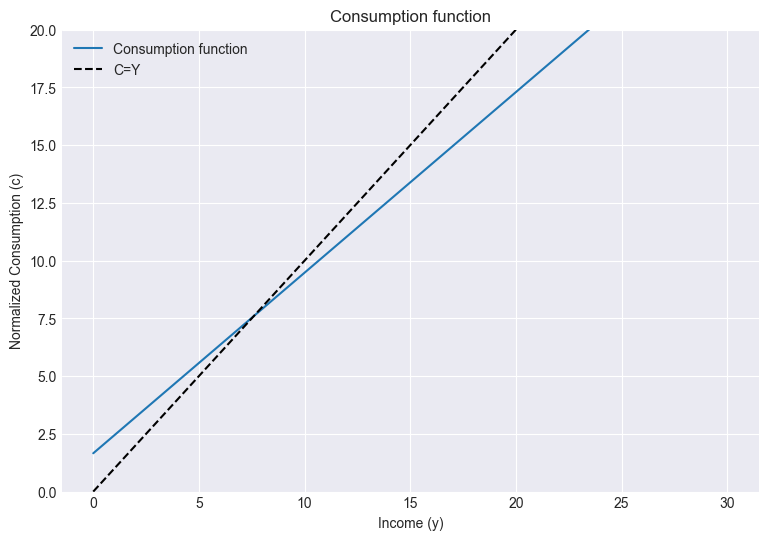

In [3]:
# Plot cFunc(Y)=Y against the Keynesian consumption function
# Deaton-Friedman consumption function is a special case of perfect foresight model

# We first create a Keynesian consumer
KeynesianExample = KeynesianConsumer()

# and then plot its consumption function
income = np.linspace(0, 30, 20) # pick some income points
plt.figure(figsize=(9,6))
plt.plot(income, KeynesianExample.cFunc(income), label = 'Consumption function') #plot income versus the consumption
plt.plot(income, income, 'k--', label = 'C=Y')
plt.title('Consumption function')
plt.xlabel('Income (y)')
plt.ylabel('Normalized Consumption (c)')
plt.ylim(0, 20)
plt.legend()
plt.show()

In [4]:
# This looks like the first of the three equations, consumption as a linear function of income!
# This means that even in a microfounded model (that HARK provides), the consumption function can match Keynes reduced form
# prediction (given the right parameterization).

# We can even find a_0 and a_1
a_0 = KeynesianExample.a0
a_1 = KeynesianExample.a1
print('a_0 is {:.2f}'.format(a_0))
print('a_1 is {:.2f}'.format(a_1))

a_0 is 1.66
a_1 is 0.78


#### The Keynesian consumption function: Evidence

Aggregate Data:

Long-term time-series estimates: $a_0$ close to zero, $a_1$ close to 1 (saving rate stable over time - Kuznets).<br>
Short-term aggregate time-series estimates of change in consumption on change in income find $a_1 << 1$.<br>
$c_t = a_0 + a_{1}y_t + a_{2}c_{t-1}$ finds significant $a_2$, near 1.

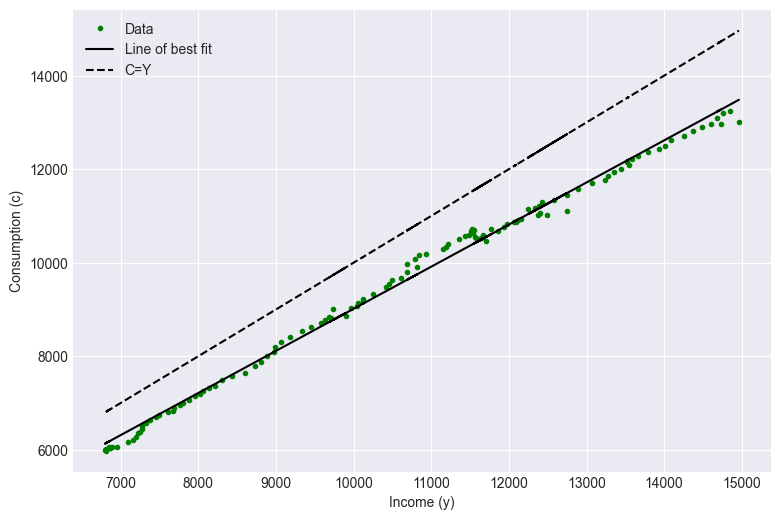

a_0 is 9.58
a_1 is 0.90


In [5]:
# Lets have a look at some aggregate data

sdt = dt.datetime(1990, 1, 1) #set startdate # dt.datetime(1980, 1, 1)
edt = dt.datetime (2020, 1, 1) #set end date # dt.datetime (2017, 1, 1)
df = web.DataReader(["PCECC96", "DPIC96"], "fred", sdt, edt) #import the data from Fred
# Plot the data
plt.figure(figsize=(9,6))
plt.plot(df.DPIC96, df.PCECC96, 'go', markersize=3.0, label='Data')
slope, intercept, r_value, p_value, std_err = stats.linregress(df.DPIC96, df.PCECC96)
plt.plot(df.DPIC96, intercept+slope*df.DPIC96, 'k-', label = 'Line of best fit')
plt.plot(df.DPIC96, df.DPIC96, 'k--', label = 'C=Y')
plt.xlabel('Income (y)')
plt.ylabel('Consumption (c)')
plt.legend()
plt.show()

print('a_0 is {:.2f}'.format(intercept))
print('a_1 is {:.2f}'.format(slope))

In [6]:
# However, our consumption data is [non-stationary](https://www.reed.edu/economics/parker/312/tschapters/S13_Ch_4.pdf) and this drives the previous
# estimate.
df.DPIC96.plot()
plt.xlabel('Date')
plt.ylabel('Consumption (c)')

Text(0, 0.5, 'Consumption (c)')

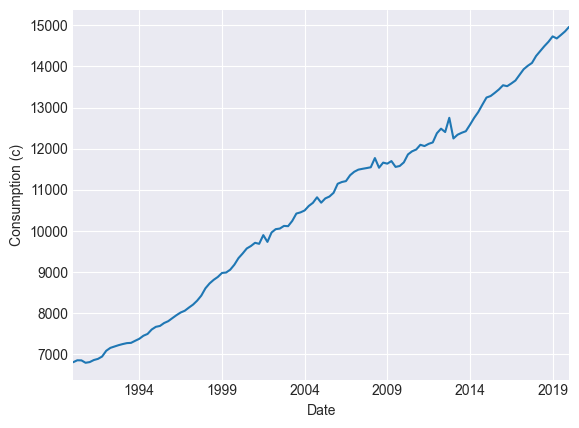

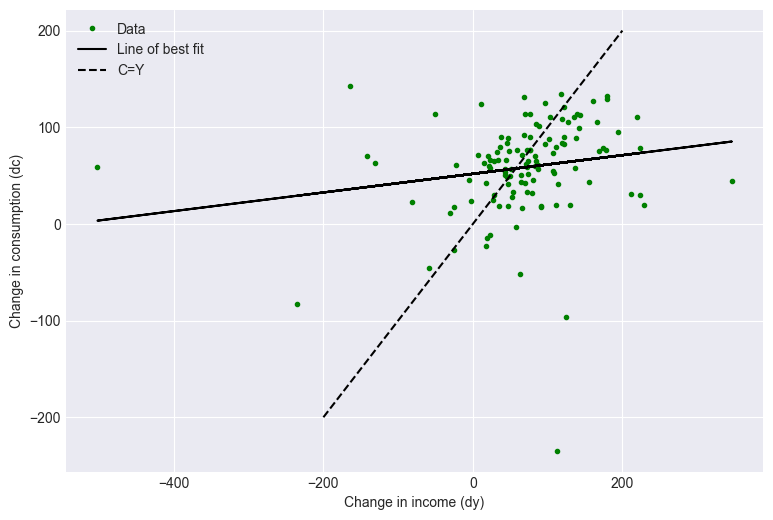

a_1 is 0.10


In [7]:
# Lets use our second equation to try to find an estimate of a_1

df_diff = df.diff() #create dataframe of differenced values

# Plot the data
plt.figure(figsize=(9,6))
plt.plot(df_diff.DPIC96, df_diff.PCECC96, 'go', markersize=3.0, label = 'Data')
slope, intercept, r_value, p_value, std_err = stats.linregress(df_diff.DPIC96[1:], df_diff.PCECC96[1:]) # find line of best fit
plt.plot(df_diff.DPIC96[1:], intercept+slope*df_diff.DPIC96[1:], 'k-', label = 'Line of best fit')
plt.plot(np.array([-200, 200]), np.array([-200, 200]), 'k--', label = 'C=Y')
plt.xlabel('Change in income (dy)')
plt.ylabel('Change in consumption (dc)')
plt.legend()
plt.show()

print('a_1 is {:.2f}'.format(slope))

a_1 is now much lower, as we expected

### Household Data:

Cross-section plots of consumption and income: very large and significant $a_0$, $a_1$ maybe 0.5. <br>

Further facts:
1. Black households save more than whites at a given income level.<br>
0. By income group:
   * low-income: Implausibly large dissaving (spend 2 or 3 times income)
   * high-income: Remarkably high saving

### 2. Duesenberry

Habit formation may explain why $c_{t-1}$ affects $c_t$.<br>
Relative Income Hypothesis suggests that you compare your consumption to consumption of ‘peers’.<br>
May explain high saving rates of Black HHs.<br>

Problems with Duesenberry: <br>
No budget constraint<br>
No serious treatment of intertemporal nature of saving

#### Dusenberry: Evidence

In [8]:
# Even if we control for income, past consumption seems to be significantly related to current consumption

df_habit = df.copy()
df_habit.columns = ['cons', 'inc']
df_habit['cons_m1'] = df.PCECC96.shift()
df_habit.dropna()

result = sm.ols(formula = "cons ~ inc + cons_m1", data=df_habit.dropna()).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   cons   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 1.063e+05
Date:                Mon, 12 Sep 2022   Prob (F-statistic):          2.07e-191
Time:                        14:16:53   Log-Likelihood:                -640.19
No. Observations:                 120   AIC:                             1286.
Df Residuals:                     117   BIC:                             1295.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     60.0419     21.302      2.819      0.006      17.854     102.230
inc            0.0350      0.027      1.277      0.204      -0.019       0.089
cons_m1        0.9608      0.030     31.635      0.000       0.901       1.021
==============================================================================
Omnibus:                       76.599   Durbin-Watson:                   1.059
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              526.877
Skew:                          -2.079   Prob(JB):                    3.89e-115
Kurtosis:                      12.385   Cond. No.                     6.70e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.7e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [9]:
# The coefficient on lagged consumption is very significant.
# But regression may be statistically problematic for the usual [non-stationarity](https://towardsdatascience.com/stationarity-in-time-series-analysis-90c94f27322) reasons.

### 3. Friedman's Permanent Income Hypothesis

$$c = p + u$$
$$y = p + v$$

We can try to test this theory across households. If we run a regression of the form:
$$c_i = a_0 + a_{1}y_{i} + u_{i}$$

And if Friedman is correct, and the "true" coefficient on permanent income $p$ is 1, then the coefficient on $y$ will be:
$$a_1 = \frac{s^2_{p}}{(s^2_{v} + s^2_{p})}$$

#### Friedman's Permanent Income Hypothesis

We begin by creating a class that class implements the Friedman PIH consumption function as a special case of the [Perfect Foresight CRRA](http://econ.jhu.edu/people/ccarroll/courses/choice/lecturenotes/consumption/PerfForesightCRRA) model.

As discussed in the lecture notes, it is often convenient to represent this type of models in variables that are normalized by permanent income. That is the case for the [HARK](https://github.com/econ-ark/HARK/) tools that we use below in the definition of our consumer. Therefore, the consumption function will expect
\begin{equation*}
y_{i,t} = \frac{Y_{i,t}}{P_{i,t}}
\end{equation*}
and compute
\begin{equation*}
c_{i,t} = \frac{C_{i,t}}{P_{i,t}}.
\end{equation*}

Therefore, to find consumption at a total level of income $Y$, we will use $\texttt{P} \times \texttt{cFunc(Y/P)}$.

In [10]:
class FriedmanPIHConsumer:
    """
    This class represents consumers that behave according to
    Friedman's permanent income hypothesis, representing them as a
    special case of HARK's PerfForesightConsumerType
    
    Methods:
    - cFunc: computes consumption/permanent income 
             given total income/permanent income.
    """
    
    def __init__(self, Rfree=1.001, CRRA = 2):
        
        FriedmanPIH = PerfForesightConsumerType() # set up a consumer type and use default parameteres
        FriedmanPIH.cycles = 0 # Make this type have an infinite horizon
        FriedmanPIH.DiscFac = 1/Rfree
        FriedmanPIH.Rfree = Rfree
        FriedmanPIH.LivPrb = [1.0]
        FriedmanPIH.PermGroFac = [1.0]
        FriedmanPIH.CRRA = CRRA
        FriedmanPIH.solve() # solve the consumer's problem
        FriedmanPIH.unpack('cFunc') # unpack the consumption function
        
        self.cFunc = FriedmanPIH.solution[0].cFunc

Now, think of a consumer that has a permanent income of 1. What will be his consumption at different levels of total observed income?

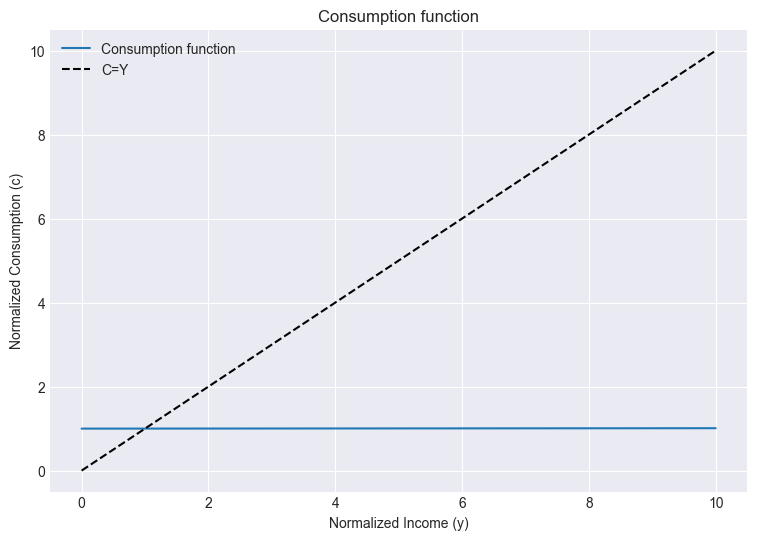

In [11]:
# We can now create a PIH consumer
PIHexample = FriedmanPIHConsumer()

# Plot the perfect foresight consumption function
income = np.linspace(0, 10, 20) # pick some income points
plt.figure(figsize=(9,6))
plt.plot(income, PIHexample.cFunc(income), label = 'Consumption function') #plot income versus the consumption
plt.plot(income, income, 'k--', label = 'C=Y')
plt.title('Consumption function')
plt.xlabel('Normalized Income (y)')
plt.ylabel('Normalized Consumption (c)')
plt.legend()
plt.show()

We can see that regardless of the income our agent receives, they consume their permanent income, which is normalized to 1.

We can also draw out some implications of the PIH that we can then test with evidence

If we look at HH's who have very similar permanent incomes, we should get a small estimate of $a_1$, because $s^2_v$ is large relative to $s^2_p$.

Lets simulate this using our consumer.

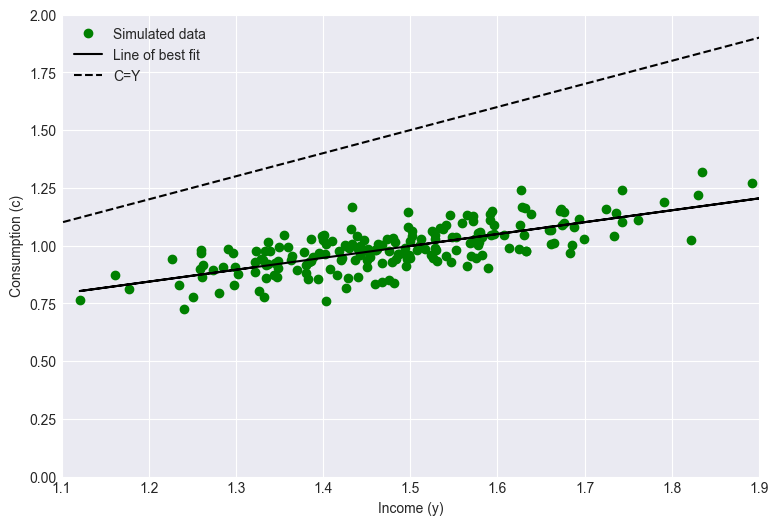

a_0 is 0.23
a_1 is 0.51


In [17]:
# Permanent income has the same variance
# as transitory income.

perm_inc = np.random.normal(1., 0.1, 200)
trans_inc = np.random.normal(0.5, 0.1, 200)

total_inc = perm_inc + trans_inc

slope, intercept, r_value, p_value, std_err = stats.linregress(total_inc, PIHexample.cFunc(total_inc/perm_inc)*perm_inc)

plt.figure(figsize=(9,6))
plt.plot(total_inc, PIHexample.cFunc(total_inc)*perm_inc, 'go', label='Simulated data')
plt.plot(total_inc, intercept + slope*total_inc, 'k-', label='Line of best fit')
plt.plot(np.linspace(1, 2, 5), np.linspace(1, 2, 5), 'k--', label='C=Y')
plt.xlabel('Income (y)')
plt.ylabel('Consumption (c)')
plt.legend()
plt.ylim(0, 2)
plt.xlim(1.1, 1.9)
plt.show()

print('a_0 is {:.2f}'.format(intercept))
print('a_1 is {:.2f}'.format(slope))

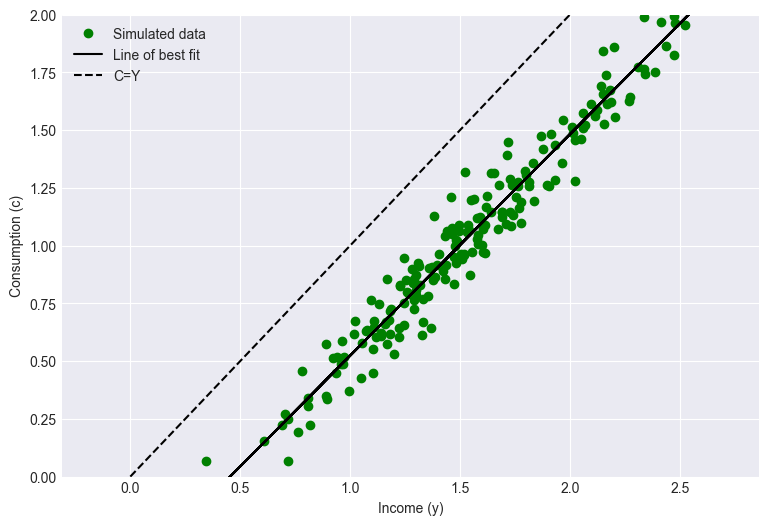

a_0 is -0.44
a_1 is 0.96


In [18]:
# Permanent income with higher variance

perm_inc = np.random.normal(1., 0.5, 200)
trans_inc = np.random.normal(0.5, 0.1, 200)

total_inc = perm_inc + trans_inc

slope, intercept, r_value, p_value, std_err = stats.linregress(total_inc, PIHexample.cFunc(total_inc/perm_inc)*perm_inc)

plt.figure(figsize=(9,6))
plt.plot(total_inc, PIHexample.cFunc(total_inc)*perm_inc, 'go', label='Simulated data')
plt.plot(total_inc, intercept + slope*total_inc, 'k-', label='Line of best fit')
plt.plot(np.linspace(0, 2, 5), np.linspace(0, 2, 5), 'k--', label='C=Y')
plt.xlabel('Income (y)')
plt.ylabel('Consumption (c)')
plt.legend()
plt.ylim(0, 2)
plt.show()

print('a_0 is {:.2f}'.format(intercept))
print('a_1 is {:.2f}'.format(slope))

We can see that as we increase the variance of permanent income, the estimate of a_1 rises

#### Friedman's Permanent Income Hypothesis: Evidence

We can now consider the empirical evidence for the claims our model made about the PIH.

If we take a long time series, then the differences in permanent income should be the main driver of the variance in total income. This implies that a_1 should be high.

If we take higher frequency time series (or cross sectional data), transitory shocks should dominate, and our estimate of a_1 should be lower.

Consider quarterly differences first:

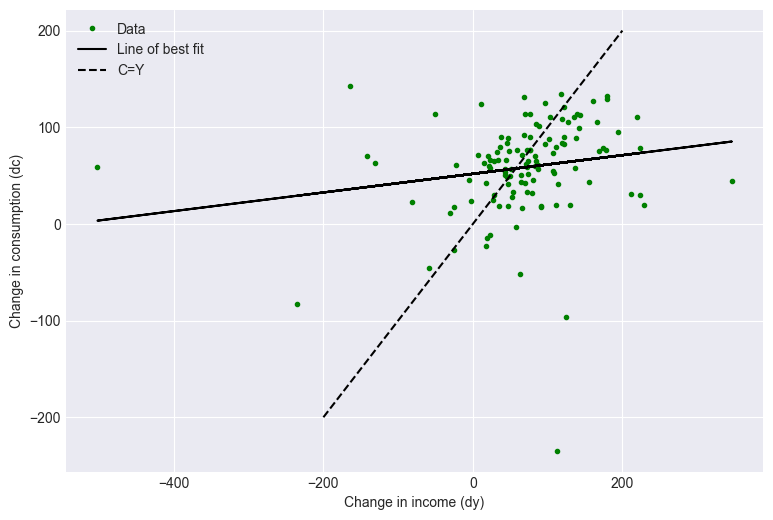

a_1 is 0.10


In [19]:
# Lets use the data from FRED that we used before.

# Using quarterly data (copying from above), we had:

plt.figure(figsize=(9,6))
plt.plot(df_diff.DPIC96, df_diff.PCECC96, 'go', markersize=3.0, label = 'Data')
slope, intercept, r_value, p_value, std_err = stats.linregress(df_diff.DPIC96[1:], df_diff.PCECC96[1:]) # find line of best fit
plt.plot(df_diff.DPIC96[1:], intercept+slope*df_diff.DPIC96[1:], 'k-', label = 'Line of best fit')
plt.plot(np.array([-200, 200]), np.array([-200, 200]), 'k--', label = 'C=Y')
plt.xlabel('Change in income (dy)')
plt.ylabel('Change in consumption (dc)')
plt.legend()
plt.show()

print('a_1 is {:.2f}'.format(slope))

And now consider longer time differences, 20 quarters for instance, where the changes in permanent income should dominate transitory effects

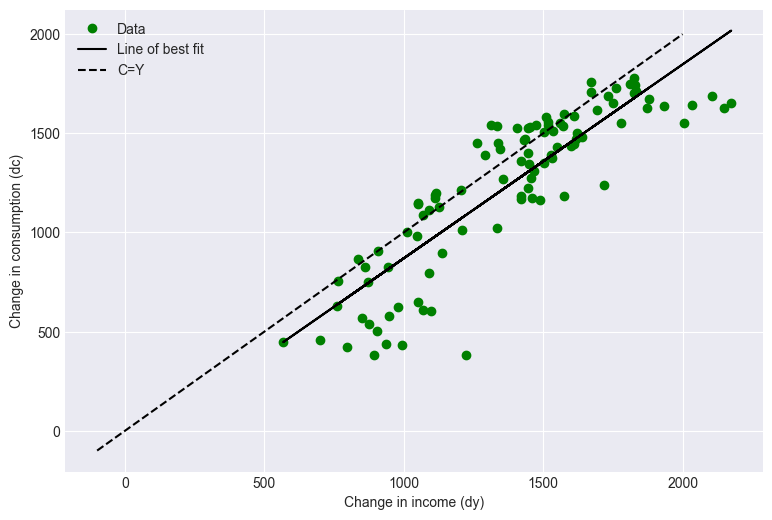

a_0 is -107.78
a_1 is 0.98


In [15]:
# Using longer differences
df_diff_long = df.diff(periods = 20) #create dataframe of differenced values
df_diff_long.columns = ['cons', 'inc']

plt.figure(figsize=(9,6))
plt.plot(df_diff_long.inc, df_diff_long.cons, 'go', label='Data')
slope, intercept, r_value, p_value, std_err = stats.linregress(df_diff_long.inc[20:], df_diff_long.cons[20:]) # find line of best fit
plt.plot(df_diff_long.inc[1:], intercept+slope*df_diff_long.inc[1:], 'k-', label='Line of best fit')
plt.plot(np.linspace(-100, 2000, 3), np.linspace(-100, 2000, 3), 'k--', label='C=Y')
plt.legend()
plt.xlabel('Change in income (dy)')
plt.ylabel('Change in consumption (dc)')
plt.show()

print('a_0 is {:.2f}'.format(intercept))
print('a_1 is {:.2f}'.format(slope))

The estimate of $a_1$ using the longer differences is much higher because permanent income is playing a much more important role in explaining the variation in consumption.